# Sampling
In this chapter we will learn how to use Python to understand sampling and sampling error.

## Sampling error
Here we will repeatedly sample from the NHANES Height variable in order to obtain the sampling distribution of the mean. First let's load the data and clean them up.

In [1]:

from nhanes.load import load_NHANES_data
nhanes_data = load_NHANES_data()
adult_nhanes_data = nhanes_data.query('AgeInYearsAtScreening > 17')
adult_nhanes_data = adult_nhanes_data.dropna(subset=['StandingHeightCm']).rename(columns={'StandingHeightCm': 'Height'})

/Users/johnbutler/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3248: DtypeWarning: Columns (142) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Now let's repeatedly sample 50 individuals from the dataset, compute the mean, and store the resulting values.  For this we are going to use a *for loop*, which allows us to repeatedly perform a particular set of actions.

In [2]:
#+
sample_size = 50
num_samples = 5000

import pandas as pd
import numpy as np

# set up a variable to store the result
sampling_results = pd.DataFrame({'mean': np.zeros(num_samples)})

for sample_num in range(num_samples):
    sample = adult_nhanes_data.sample(sample_size)
    sampling_results.loc[sample_num, 'mean'] = sample['Height'].mean()
#-

Now let's plot the sampling distribution.  We will also overlay the sampling distribution of the mean predicted on the basis of the population mean and standard deviation, to show that it properly describes the actual sampling distribution.  We also place a vertical line at the population mean.

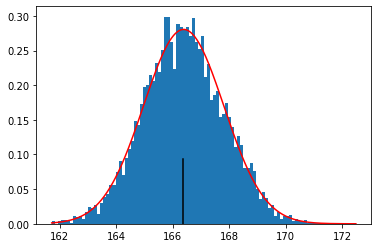

In [4]:
#+
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
import seaborn as sns

hist = plt.hist(sampling_results['mean'], 100, density=True)
# hist[0] contains the histogram data
# we need to use the maximum of those data to set
# the height of the vertical line that shows the mean
plt.axvline(x=adult_nhanes_data['Height'].mean(),
            ymax=np.max(hist[0]), color='k')

# draw the normal distribution with same mean and standard deviation
# as the sampling distribution
hist_bin_min = np.min(hist[1])
hist_bin_max = np.max(hist[1])
step_size = 0.01
x_values = np.arange(hist_bin_min, hist_bin_max, step_size)
normal_values = scipy.stats.norm.pdf(
    x_values,
    loc=sampling_results['mean'].mean(),
    scale=sampling_results['mean'].std())
plt.plot(x_values, normal_values, color='r')
plt.show()
#+

## Central limit theorem
The central limit theorem tells us that the sampling distribution of the mean becomes normal as the sample size grows.  Let's test this by sampling a clearly non-normal variable and look at the normality of the results using a Q-Q plot. For example, let's look at the variable that represents annual family income.  This variable is oddly distributed:

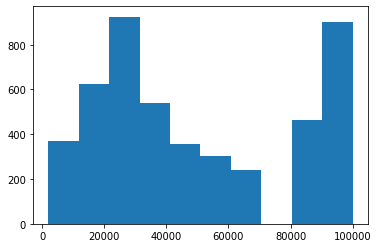

In [11]:
plt.hist(adult_nhanes_data['AnnualFamilyIncome'])
plt.show()

This odd distribution comes in part from the how the variable is coded, as shown [here](https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/DEMO_J.htm#INDFMIN2). Let's resample this variable 5000 times, compute the mean, and examine the distribution.  To do this, we will create a function that resamples and returns the mean:

In [12]:
def sample_and_return_mean(df, variable_name, 
                           sample_size=250, num_samples=5000):
    """
    repeatedly take samples from a particular variable in a data frame
    and compute the mean

    Parameters:
    -----------
    df: data frame containing the data
    variable_name: the name of the variable to be analyzed
    sample_size: the number of observations to sample each time
    num_samples: the number of samples to take

    Returns:
    --------
    sampling_distribution: data frame containing the means
    """
    sampling_distribution = pd.DataFrame({'mean': np.zeros(num_samples)})
    for sample_number in range(num_samples):
        sample_df = df.sample(sample_size)
        sampling_distribution.loc[sample_number, 'mean'] = sample_df[variable_name].mean()
    return(sampling_distribution)

Now, using this function, let's compute the sampling distribution for the annual family income variable and plot its histogram. 

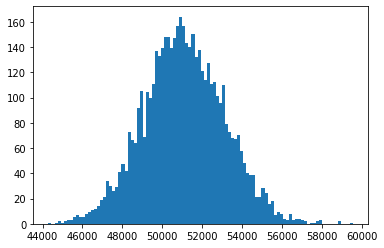

In [13]:
adult_income_data = adult_nhanes_data.dropna(subset=['AnnualFamilyIncome'])
family_income_sampling_dist = sample_and_return_mean(adult_income_data, 'AnnualFamilyIncome')
_ = plt.hist(family_income_sampling_dist['mean'], 100)

This distribution looks nearly normal.  We can also use a quantile-quantile, or "Q-Q" plot, to examine this.  We will plot two Q-Q plots; on the left we plot one for the original data, and on the right we plot one for the sampling distribution of the mean.

Text(0.5, 1.0, 'Sampling distribution')

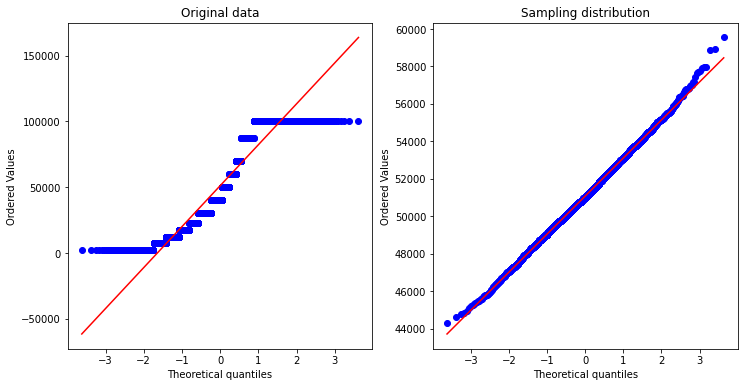

In [15]:

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
scipy.stats.probplot(adult_income_data['AnnualFamilyIncome'], plot=sns.mpl.pyplot)
plt.title('Original data')

plt.subplot(1, 2, 2)
scipy.stats.probplot(family_income_sampling_dist['mean'], plot=sns.mpl.pyplot)
plt.title('Sampling distribution')


We see that the raw data are highly non-normal, evidenced by the fact that the data values diverge greatly from the unit line.  On the other hand, the sampling distribution looks much more normally distributed.

## Confidence intervals

Remember that confidence intervals are intervals that will contain the population parameter in a certain proportion of samples from the population.  In this example we will walk through [the simulation that was presented in the book](https://statsthinking21.github.io/statsthinking21-core-site/sampling.html#confidence-intervals) to show that this actually works properly.  To do this, let's create a function that takes a sample from the NHANES population and returns the confidence interval for the mean of the `Height` variable within that sample.  We will use the t distribution to obtain our confidence intervals.

In [16]:
def get_confidence_interval(df, variable_name, 
                            ci_percent=95,
                            sample_size=50):
    sample_df = df.sample(sample_size)
    mean = sample_df[variable_name].mean()
    std = sample_df[variable_name].std()
    sem = std / np.sqrt(sample_size)
    t_tail_proportion = 1 - ((100 - ci_percent) / 100) / 2
    t_cutoff = scipy.stats.t.ppf(t_tail_proportion, sample_size - 1)
    upper_ci = mean + sem * t_cutoff
    lower_ci = mean - sem * t_cutoff
    return([lower_ci, upper_ci])

Using this function, let's resample the data 1000 times and look how often the resulting interval contains the population mean.

In [17]:

num_runs = 1000

ci_df = pd.DataFrame({'lower': np.zeros(num_runs),
                      'upper': np.zeros(num_runs)})

for i in range(num_runs):
    ci_df.iloc[i, :] = get_confidence_interval(
        adult_nhanes_data,
        'Height'
    )

Now we need to compute the proportion of confidence intervals that capture the population mean (which we know because we are treating the entire NHANES dataset as our population).  Here we will use a trick that relies upon the fact that Python treat `True`/`False` identically to one and zero respectively.  We will test for each of the confidence limits (upper and lower) whether it captures the population mean, and then we will multiply those two series of values together.  This will create a new variable that is True only if both limits capture the population mean. We then simply take the mean of those truth values to compute the poportion of confidence intervals that capture the mean.

In [18]:
ci_df['captures_mean'] = (ci_df['lower'] < adult_nhanes_data['Height'].mean()) * (ci_df['upper'] > adult_nhanes_data['Height'].mean())

ci_df['captures_mean'].mean()

/Users/johnbutler/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


0.956

This number should be very close to 0.95.